In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
app_df = pd.read_csv("application_data.csv")

# 1.Drop features 

In [3]:
#missing data 
missing_fractions = app_df.isnull().mean().sort_values(ascending=False)
missing_fractions.head(10)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
dtype: float64

# Limit the Feature Space
The full dataset has 122 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

# 1.1 Drop features missing more than 30% percent data

In [5]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
app_df.drop(labels=drop_list, axis=1, inplace=True)

# Columns of choice

In [6]:
#useless columns:
["SK_ID_CURR"]
app_df.drop(labels=["SK_ID_CURR"], axis=1, inplace=True)

# Pearson correlation matrix

In [7]:
# indicator (dummy variable) whether the applicant provided ...
Flag=['FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [8]:
app_df_2=app_df.drop(labels=Flag, axis=1)

<AxesSubplot:title={'center':'Pearson Correlation Matrix'}>

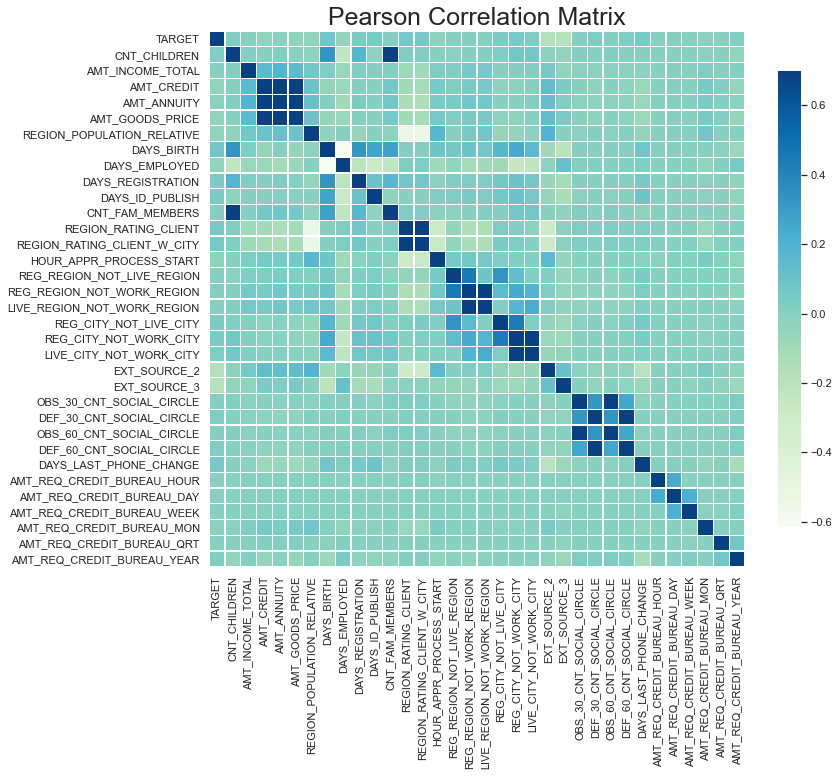

In [9]:
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(app_df_2.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=False, cbar_kws={"shrink": .7})

# 3. Your code

In [10]:
#  one-hot encoding is not necessary for some models! Please be aware.
app_df=pd.get_dummies(app_df)

In [11]:
#app_df is for everyone and app_df_3 is for linear model

In [12]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# data processing
app_df = app_df.dropna()
X = app_df.drop('TARGET', axis=1) 
y = app_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Basic Tree Model

In [13]:
# Decision Tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

# Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
print('Accuracy before tuning for Decision Tree', clf.score(X_test, y_test))
print('Accuracy before tuning for Random Forests', clf_rf.score(X_test, y_test))

Accuracy before tuning for Decision Tree 0.8574070297097015
Accuracy before tuning for Random Forests 0.9220885172343464


# Turned Tree Model

In [15]:
#Decision Tree:
clf_param_grid = {'max_depth' : range(1,clf.tree_.max_depth),
              'max_features' : [.2, .4, .6, .8]}
grid_search = GridSearchCV(clf, clf_param_grid, cv = 5)
grid_search.fit(X_train, y_train)
print("Best Parameters for a CV Decision Tree:", grid_search.best_params_)


Best Parameters for a CV Decision Tree: {'max_depth': 4, 'max_features': 0.4}


In [16]:
#RandomForest Tree:
clf_rf_param_grid = [{'n_estimators' : [3,10,30], 'max_features' : [2,4,6,8]},
              {'bootstrap' : [False], 'n_estimators' : [3,10], 'max_features' : [2,3,4]}]

grid_search = GridSearchCV(clf_rf, clf_rf_param_grid, cv = 5)
grid_search.fit(X_train, y_train)
print("Best Parameters for a CV Random Forests Model:", grid_search.best_params_)


Best Parameters for a CV Random Forests Model: {'max_features': 8, 'n_estimators': 30}


In [17]:
best_clf = tree.DecisionTreeClassifier(max_depth = 4, max_features = 0.4)
best_clf.fit(X_train,y_train)
print('Accuracy after tuning for Decision Tree', best_clf.score(X_test, y_test))


best_clf_rf = RandomForestClassifier(max_features = 8, n_estimators = 30)
best_clf_rf.fit(X_train, y_train)
print('Accuracy after tuning for Random Forests', best_clf_rf.score(X_test, y_test))

Accuracy after tuning for Decision Tree 0.9220069345298797
Accuracy after tuning for Random Forests 0.9220205316472908


In [21]:
best_clf_predictions = best_clf.predict(X_test)
print("Presion Score for tuned Decision tree Model:",precision_score(y_test, best_clf_predictions,labels=np.unique(best_clf_predictions)))
print("F1 for tuned Decision tree Model:",f1_score(y_test, best_clf_predictions,labels=np.unique(best_clf_predictions)))
print("Recall for tuned Decision tree Model:",recall_score(y_test, best_clf_predictions))
print("ROC AUC for tuned Decision tree Model:", roc_auc_score(y_test, best_clf_predictions))
print("Classification Report:", classification_report(y_test, best_clf_predictions))

F1 for tuned Decision tree Model: 0.0
Recall for tuned Decision tree Model: 0.0
ROC AUC for tuned Decision tree Model: 0.5


In [ ]:
best_clf_rf_predictions = best_clf_rf.predict(X_test)
print("Presion Score for tuned Random Forest tree Model:",precision_score(y_test, best_clf_rf_predictions,labels=np.unique(best_clf_rf_predictions)))
print("F1 for tuned Random Forest tree Model:",f1_score(y_test, best_clf_rf_predictions,labels=np.unique(best_clf_rf_predictions)))
print("Recall for tuned Random Forest tree Model:",recall_score(y_test, best_clf_rf_predictions))
print("ROC AUC for tuned Random Forest tree Model:", roc_auc_score(y_test, best_clf_rf_predictions))
print("Classification Report:", classification_report(y_test, best_clf_rf_predictions))

# KNearestNeighbors

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
X = app_df.drop('TARGET', axis=1) 
y = app_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2)
knn_c = KNeighborsClassifier()
knn_c.fit(X_train, y_train)
print("Accuracy of untuned KNN Classifier", knn_c.score(X_test, y_test))


Accuracy of untuned KNN Classifier 0.9166088789176694


# Turning K

In [ ]:
param_grid = {'weights': ['distance', 'uniform'], 'n_neighbors': [i for i in range(1,15)]}
grid_search = GridSearchCV(knn_c, param_grid, scoring = "accuracy")
grid_search.fit(X, y)
grid_search.best_params_

In [ ]:
grid_search.best_estimator_.fit(X_train, y_train)
print("Test Accuracy:",grid_search.best_estimator_.score(X_test, y_test))

In [ ]:
print("Training Accuracy:", grid_search.best_estimator_.score(X_train, y_train))

In [ ]:
# confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)  
plt.show()

# cross validation  and tune parameters
# need the following 
 precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report